# Test Door Key Offline Training with d3rlpy and Decision Transformer

We will use the Door Key 16x16 environment from Minigrid Gym to test the Decision Transformer algorithm from d3rlpy.

In [145]:
# Test if we are running on CoLab or not
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  !apt-get install -y xvfb ffmpeg > /dev/null 2>&1
  %pip install pyvirtualdisplay pygame moviepy > /dev/null 2>&1
  %pip install d3rlpy
  %pip install matplotlib
else:
  print('Not running on CoLab')

Not running on CoLab


In [146]:
# Directory creation
import os
path = "./models"
isExist = os.path.exists(path)
if not isExist:
  os.makedirs(path)

path = "./datasets"
isExist = os.path.exists(path)
if not isExist:
  os.makedirs(path)

path = "./videos/video-doorkey-dt-d3rlpy"
isExist = os.path.exists(path)
if not isExist:
  os.makedirs(path)

In [147]:
import gymnasium as gym
from gymnasium import spaces
from minigrid.envs import DoorKeyEnv
from gymnasium.core import ActType, ObsType
from typing import Any, SupportsFloat
import random, math
import numpy as np

from gymnasium.envs.registration import register

register(
    id="MiniGrid-DoorKey-16x16-v0",
    entry_point="minigrid.envs:DoorKeyEnv",
    kwargs={"size": 16},
)
    

/home/drinf/anaconda3/envs/decision-transformers/lib/python3.10/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment MiniGrid-DoorKey-16x16-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


We made a PartialObsWrapper to add to flattened partial observations the direction of the agent in only one vector. This is useful to train the Decision Transformer algorithm.

We also made a PartialAndFullyObsWrapper to add to flattened partial observations the direction of the agent in only one vector and to add the full observation to the partial observation. This is useful to sample data from the environment with the trained DQN agent, and for save the data in a dataset.

In [148]:
import minigrid
from minigrid.core.constants import COLOR_TO_IDX, OBJECT_TO_IDX
from gymnasium.core import ObservationWrapper

class PartialObsWrapper(ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)

        new_image_space = spaces.Box(
            low=0,
            high=255,
            shape=(((self.env.agent_view_size * self.env.agent_view_size *  3) + 1),),  
            dtype="uint8",
        )

        self.observation_space = spaces.Dict(
            {**self.observation_space.spaces, "image": new_image_space}
        )

    def observation(self, obs):
        image = np.concatenate((obs["image"].flatten(), np.array([obs["direction"]])))

        return {"image": image}

class PartialAndFullyObsWrapper(ObservationWrapper):

    def __init__(self, env):
        super().__init__(env)

        new_image_space = spaces.Box(
            low=0,
            high=255,
            shape=(self.env.width, self.env.height, 3),  # number of cells
            dtype="uint8",
        )

        self.observation_space = spaces.Dict(
            {**self.observation_space.spaces, "image": new_image_space}
        )

    def observation(self, obs):
        env = self.unwrapped
        full_grid = env.grid.encode()
        full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array(
            [OBJECT_TO_IDX["agent"], COLOR_TO_IDX["red"], env.agent_dir]
        )

        partial_image = np.concatenate((obs["image"].flatten(), np.array([obs["direction"]])))

        return {"partial_image": partial_image, "image": full_grid}

def create_env(env_key, max_episode_steps=100, isPartialObs=False, isFullyObs=True, is_video=False):
    
    render_mode = None

    if is_video == True:
        render_mode = 'rgb_array'

    env = gym.make(env_key, max_episode_steps=max_episode_steps, render_mode=render_mode, see_through_walls=True)

    if isPartialObs and isFullyObs:
        env =  PartialAndFullyObsWrapper(env)
    elif isPartialObs:
        env = PartialObsWrapper(env)
        env = minigrid.wrappers.ImgObsWrapper(env)
    elif isFullyObs:
        env = minigrid.wrappers.FullyObsWrapper(env)
        env = minigrid.wrappers.ImgObsWrapper(env)

    return env


We recover the agent DQN trained in the notebook train-door-key-16x16-dqn.ipynb. We use this agent to sample data from the environment and to save the data in a dataset. This is a way to use the trained agent to generate data for the Decision Transformer algorithm with expert data. This agent is also used to evaluate the performance of the Decision Transformer algorithm. The agent is good enough to solve the environment, but not perfect.

In [149]:
import d3rlpy
import gymnasium as gym
import torch
import torch.nn as nn
from d3rlpy.models.encoders import EncoderFactory

class CustomConvEncoder(nn.Module):
    def __init__(self, observation_shape):
        super().__init__()
        print(observation_shape)

        self.conv1 = nn.Conv2d(3, 32, kernel_size=1, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv2Dropout = nn.Dropout(0.25)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv3Dropout = nn.Dropout(0.5)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.conv4Dropout = nn.Dropout(0.5)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.conv5Dropout = nn.Dropout(0.5)


    def forward(self, x):
        h = x.permute(0, 3, 1, 2)
        h = torch.relu(self.conv1(h))
        h = torch.relu(self.conv2Dropout(self.conv2(h)))
        h = torch.relu(self.conv3Dropout(self.conv3(h)))
        h = torch.relu(self.conv4Dropout(self.conv4(h)))
        h = torch.relu(self.conv5Dropout(self.conv5(h)))

        h = torch.flatten(h, start_dim=1)
        #print(h.shape)

        return h
    
class CustomConvEncoderFactory(EncoderFactory):

    def create(self, observation_shape):
        return CustomConvEncoder(observation_shape)

    @staticmethod
    def get_type() -> str:
        return "custom"
    


In [150]:
config = {
    "seed": 1,
    "dataset_size": 10000,
    "epsilon": 0.3,
    "max_episode_steps": 200,
    "experiment_name": "door-key-16x16",
    "device": "cuda:0"
}

env_key = "MiniGrid-DoorKey-16x16-v0"

env = create_env(env_key, max_episode_steps=config["max_episode_steps"])

dqn = d3rlpy.algos.DQNConfig(
    encoder_factory=CustomConvEncoderFactory(),
    batch_size=100,
    gamma=0.9,
    target_update_interval=1000,
    learning_rate=2.5e-4
).create(device=config["device"])

dqn.build_with_env(env)

dqn.load_model('./models/model_door-key-dqn-16x16.pt')


(16, 16, 3)
(16, 16, 3)


/home/drinf/anaconda3/envs/decision-transformers/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.width to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.width` for environment variables or `env.get_wrapper_attr('width')` that will search the reminding wrappers.
  logger.warn(
/home/drinf/anaconda3/envs/decision-transformers/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.height to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.height` for environment variables or `env.get_wrapper_attr('height')` that will search the reminding wrappers.
  logger.warn(


We create a CustomReplayBuffer to clip episodes with zero or negative rewards. We want to clip the episodes to only include the steps where the agent is making progress towards the goal.

In [151]:
import numpy as np
from tqdm import tqdm


class CustomReplayBuffer(d3rlpy.dataset.ReplayBuffer):
    ' Custom Replay Buffer to clip episodes with negative rewards'
    
    def clip_episode(self, terminated: bool) -> None:
        r"""Clips the current episode.

        Args:
            terminated: Flag to represent environment termination.
        """

        episode_to_remove = None
        # Check if the episode's reward is 0 or negative
        if not terminated and self._writer._active_episode.rewards.mean() <= 0:
            episode_to_remove = self._writer._active_episode
            
        self._writer.clip_episode(terminated)

        if episode_to_remove is not None:
            # Remove all transitions associated with the episode to remove
            self._buffer._transitions = [(ep, idx) for ep, idx in self._buffer._transitions if ep is not episode_to_remove]
            self._buffer.episodes.remove(episode_to_remove)  



We fill the buffer dataset with the data sampled from the environment with the trained agent DQN. We use the PartialAndFullyObsWrapper to use the full observation for the DQN agent and to save the partial observation in the dataset. We make samples until we have the dataset filled with only positive rewards. To generate a mixed non-expert / exper data, we start adding more entropy to the actions sampled from the DQN agent and progressively decrease the entropy to generate expert data. It is an slow process, but it is the only way we found to generate expert data automatically.

In [152]:
env_data = create_env(env_key, max_episode_steps=config["max_episode_steps"], isPartialObs=True, isFullyObs=False)
env_sampler = create_env(env_key, max_episode_steps=config["max_episode_steps"], isPartialObs=True, isFullyObs=True)

buffer = d3rlpy.dataset.InfiniteBuffer()
dataset = CustomReplayBuffer(buffer, env=env_data, cache_size=config["max_episode_steps"])

seed = 1

done = False

observation, _ = env_sampler.reset()

num_steps = 0
count_done = 0
count_truncated = 0

epsilon = 0.5
epsilon_min = 0.1
epsilon_decrement = (epsilon - epsilon_min) / 10  


pbar = tqdm(total=config["dataset_size"])

while dataset.size() < config["dataset_size"]:

    pbar.update(dataset.size() - pbar.n) 

    if dataset.size() >= (config["dataset_size"] * (1 - (epsilon - epsilon_min) / (epsilon - epsilon_decrement))):
        epsilon = max(epsilon - epsilon_decrement, epsilon_min)

    explorer = d3rlpy.algos.ConstantEpsilonGreedy(epsilon=epsilon)

    while True:
        x = np.expand_dims(observation['image'], axis=0)

        action = explorer.sample(dqn, x, 0)[0]

        next_observation, reward, done, truncated, _ = env_sampler.step(action)

        clip_episode = done or truncated

        # store observation
        dataset.append(observation['partial_image'], action, float(reward))

        # reset if terminated
        if clip_episode:
            dataset.clip_episode(done)
            observation, _ = env_sampler.reset()
            if done:
                count_done += 1
            if truncated:
                count_truncated += 1
            break
        else:
            observation = next_observation

pbar.close()
env.close()

print("Dataset size: ", dataset.size())
print("Truncated: ", count_truncated)

dataset.dump('./datasets/dataset_door-key-dqn-16x16-mixed.d3')


2024-01-22 00:40.58 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('uint8')], shape=[(148,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2024-01-22 00:40.58 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2024-01-22 00:40.58 [info     ] Action size has been automatically determined. action_size=7


/home/drinf/anaconda3/envs/decision-transformers/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.agent_view_size to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.agent_view_size` for environment variables or `env.get_wrapper_attr('agent_view_size')` that will search the reminding wrappers.
  logger.warn(
  1%|          | 82/10000 [00:35<1:18:22,  2.11it/s]

KeyboardInterrupt: 

We train the DiscreteDecisionTransformer agent with the sampled data from the environment. We use the PartialObsWrapper to add the direction of the agent to the partial observation.

In [ ]:
env_dt = create_env(env_key, max_episode_steps=config["max_episode_steps"], isPartialObs=True, isFullyObs=False)
env_dt_eval = create_env(env_key, max_episode_steps=config["max_episode_steps"], isPartialObs=True, isFullyObs=False)

buffer = d3rlpy.dataset.InfiniteBuffer()
dataset = CustomReplayBuffer(buffer, env=env_dt, cache_size=config["max_episode_steps"])

dataset.load('./datasets/dataset_door-key-dqn-16x16-mixed.d3', buffer=buffer)


target_return = 1
experiment_name = config["experiment_name"]
experiment_seed = config["seed"]

dt = d3rlpy.algos.DiscreteDecisionTransformerConfig(
    batch_size=64,
    learning_rate=1e-4,
    optim_factory=d3rlpy.models.AdamWFactory(weight_decay=1e-4),
    encoder_factory=d3rlpy.models.VectorEncoderFactory(
        [128],
        exclude_last_activation=True,
    ),
    #observation_scaler=d3rlpy.preprocessing.StandardObservationScaler(),
    #reward_scaler=d3rlpy.preprocessing.MultiplyRewardScaler(0.001),
    position_encoding_type=d3rlpy.PositionEncodingType.GLOBAL,
    context_size=50,
    num_heads=4,
    num_layers=3,
    max_timestep=200,
).create(device=config["device"])


dt.fit(                                                                                                                                                                                                                                                                                                                                                                                                                                                             
    dataset,
    n_steps=20000,
    n_steps_per_epoch=2000,
    eval_env=env_dt_eval,
    eval_target_return=1,
    eval_action_sampler=d3rlpy.algos.SoftmaxTransformerActionSampler(
        temperature=1.0,
    ),
    experiment_name=f"DT_{experiment_name}_{experiment_seed}"
)


2024-01-21 23:07.47 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('uint8')], shape=[(148,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2024-01-21 23:07.47 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2024-01-21 23:07.47 [info     ] Action size has been automatically determined. action_size=7
2024-01-21 23:07.54 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('uint8')], shape=[(148,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)])
2024-01-21 23:07.54 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2024-01-21 23:07.54 [info     ] Action size has been automatically determined. action_size=7
2024-01-21 23

Epoch 1/10:   0%|          | 0/2000 [00:00<?, ?it/s]

2024-01-21 23:09.17 [info     ] DT_door-key-16x16_1_20240121230754: epoch=1 step=2000 epoch=1 metrics={'time_sample_batch': 0.006913616299629211, 'time_algorithm_update': 0.03026457130908966, 'loss': 0.848791387706995, 'learning_rate': 9.818605497212029e-05, 'time_step': 0.0373171226978302, 'environment': 0.28428515625} step=2000
2024-01-21 23:09.17 [info     ] Model parameters are saved to d3rlpy_logs/DT_door-key-16x16_1_20240121230754/model_2000.d3


Epoch 2/10:   0%|          | 0/2000 [00:00<?, ?it/s]

2024-01-21 23:10.36 [info     ] DT_door-key-16x16_1_20240121230754: epoch=2 step=4000 epoch=2 metrics={'time_sample_batch': 0.006858097910881042, 'time_algorithm_update': 0.028980084180831908, 'loss': 0.7375048235058784, 'learning_rate': 8.835054443637522e-05, 'time_step': 0.03596951162815094, 'environment': 0.67387890625} step=4000
2024-01-21 23:10.36 [info     ] Model parameters are saved to d3rlpy_logs/DT_door-key-16x16_1_20240121230754/model_4000.d3


Epoch 3/10:   0%|          | 0/2000 [00:00<?, ?it/s]

2024-01-21 23:11.54 [info     ] DT_door-key-16x16_1_20240121230754: epoch=3 step=6000 epoch=3 metrics={'time_sample_batch': 0.006928563475608825, 'time_algorithm_update': 0.0291766277551651, 'loss': 0.7194353715181351, 'learning_rate': 7.04769782418929e-05, 'time_step': 0.03624347460269928, 'environment': 0.6786953124999999} step=6000
2024-01-21 23:11.54 [info     ] Model parameters are saved to d3rlpy_logs/DT_door-key-16x16_1_20240121230754/model_6000.d3


Epoch 4/10:   0%|          | 0/2000 [00:00<?, ?it/s]

2024-01-21 23:13.12 [info     ] DT_door-key-16x16_1_20240121230754: epoch=4 step=8000 epoch=4 metrics={'time_sample_batch': 0.007049693107604981, 'time_algorithm_update': 0.029266536712646483, 'loss': 0.7109014772176743, 'learning_rate': 4.8330853337870506e-05, 'time_step': 0.03645717906951904, 'environment': 0.782703125} step=8000
2024-01-21 23:13.12 [info     ] Model parameters are saved to d3rlpy_logs/DT_door-key-16x16_1_20240121230754/model_8000.d3


Epoch 5/10:   0%|          | 0/2000 [00:00<?, ?it/s]

2024-01-21 23:14.31 [info     ] DT_door-key-16x16_1_20240121230754: epoch=5 step=10000 epoch=5 metrics={'time_sample_batch': 0.006913050174713135, 'time_algorithm_update': 0.029357316613197328, 'loss': 0.7032193146944046, 'learning_rate': 2.6572727688173935e-05, 'time_step': 0.036407352209091186, 'environment': 0.49040234375} step=10000
2024-01-21 23:14.31 [info     ] Model parameters are saved to d3rlpy_logs/DT_door-key-16x16_1_20240121230754/model_10000.d3


Epoch 6/10:   0%|          | 0/2000 [00:00<?, ?it/s]

2024-01-21 23:15.50 [info     ] DT_door-key-16x16_1_20240121230754: epoch=6 step=12000 epoch=6 metrics={'time_sample_batch': 0.006854774832725525, 'time_algorithm_update': 0.029251161575317382, 'loss': 0.700837476849556, 'learning_rate': 1.1513394412753156e-05, 'time_step': 0.03623122715950012, 'environment': 0.5836171875} step=12000
2024-01-21 23:15.50 [info     ] Model parameters are saved to d3rlpy_logs/DT_door-key-16x16_1_20240121230754/model_12000.d3


Epoch 7/10:   0%|          | 0/2000 [00:00<?, ?it/s]

2024-01-21 23:17.10 [info     ] DT_door-key-16x16_1_20240121230754: epoch=7 step=14000 epoch=7 metrics={'time_sample_batch': 0.006803167223930359, 'time_algorithm_update': 0.029262224793434145, 'loss': 0.7001724973171949, 'learning_rate': 9.999999999999677e-06, 'time_step': 0.03618792617321014, 'environment': 0.57289453125} step=14000
2024-01-21 23:17.10 [info     ] Model parameters are saved to d3rlpy_logs/DT_door-key-16x16_1_20240121230754/model_14000.d3


Epoch 8/10:   0%|          | 0/2000 [00:00<?, ?it/s]

2024-01-21 23:18.29 [info     ] DT_door-key-16x16_1_20240121230754: epoch=8 step=16000 epoch=8 metrics={'time_sample_batch': 0.0068625063896179195, 'time_algorithm_update': 0.02899527406692505, 'loss': 0.700576818048954, 'learning_rate': 9.999999999999677e-06, 'time_step': 0.03597722971439361, 'environment': 0.38885546875} step=16000
2024-01-21 23:18.29 [info     ] Model parameters are saved to d3rlpy_logs/DT_door-key-16x16_1_20240121230754/model_16000.d3


Epoch 9/10:   0%|          | 0/2000 [00:00<?, ?it/s]

2024-01-21 23:19.45 [info     ] DT_door-key-16x16_1_20240121230754: epoch=9 step=18000 epoch=9 metrics={'time_sample_batch': 0.006600202441215515, 'time_algorithm_update': 0.028705960631370545, 'loss': 0.7002915351688862, 'learning_rate': 1.4394318749096963e-05, 'time_step': 0.03543077301979065, 'environment': 0.87271875} step=18000
2024-01-21 23:19.45 [info     ] Model parameters are saved to d3rlpy_logs/DT_door-key-16x16_1_20240121230754/model_18000.d3


Epoch 10/10:   0%|          | 0/2000 [00:00<?, ?it/s]

2024-01-21 23:21.02 [info     ] DT_door-key-16x16_1_20240121230754: epoch=10 step=20000 epoch=10 metrics={'time_sample_batch': 0.006708921909332276, 'time_algorithm_update': 0.0285303715467453, 'loss': 0.7014753077924252, 'learning_rate': 3.2780393187148524e-05, 'time_step': 0.035367817401885986, 'environment': 0.7673398437500001} step=20000
2024-01-21 23:21.02 [info     ] Model parameters are saved to d3rlpy_logs/DT_door-key-16x16_1_20240121230754/model_20000.d3


We make a video of the trained agent.

In [ ]:
import gymnasium as gym

import numpy as np
from gym.wrappers import RecordVideo


# start virtual display
d3rlpy.notebook_utils.start_virtual_display()

env_video = create_env(env_key, max_episode_steps=200, is_video=True, isPartialObs=True, isFullyObs=False)

env_video = RecordVideo(env_video, './videos/video-doorkey-dt-d3rlpy')

seed = 0


# wrap as stateful actor for interaction
actor = dt.as_stateful_wrapper(
    target_return=1,
    action_sampler=d3rlpy.algos.SoftmaxTransformerActionSampler(temperature=1.0,)
)

done = False

actor.reset()
observation, reward = env_video.reset(seed=seed)

while True:

    action = actor.predict(observation, 1) 

    observation, reward, done, truncated, _ = env_video.step(action)

    if done:
        print("reward:", reward)
        print("DONE!!!")
        break
    elif truncated:
        print("Truncated")
        break

env.close()

d3rlpy.notebook_utils.render_video("./videos/video-doorkey-dt-d3rlpy/rl-video-episode-0.mp4")


/home/drinf/anaconda3/envs/decision-transformers/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.agent_view_size to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.agent_view_size` for environment variables or `env.get_wrapper_attr('agent_view_size')` that will search the reminding wrappers.
  logger.warn(
/home/drinf/anaconda3/envs/decision-transformers/lib/python3.10/site-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /home/drinf/Desktop/PROJECTS/machine_learning/fib_postgraduate/GameMindsDT/experiments/notebooks/videos/video-doorkey-dt-d3rlpy folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/home/drinf/anaconda3/envs/decision-transformers/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.is_vector_env to get variables from other wrappers is dep

Moviepy - Building video /home/drinf/Desktop/PROJECTS/machine_learning/fib_postgraduate/GameMindsDT/experiments/notebooks/videos/video-doorkey-dt-d3rlpy/rl-video-episode-0.mp4.
Moviepy - Writing video /home/drinf/Desktop/PROJECTS/machine_learning/fib_postgraduate/GameMindsDT/experiments/notebooks/videos/video-doorkey-dt-d3rlpy/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/drinf/Desktop/PROJECTS/machine_learning/fib_postgraduate/GameMindsDT/experiments/notebooks/videos/video-doorkey-dt-d3rlpy/rl-video-episode-0.mp4
reward: 0.9644921875
DONE!!!


In [ ]:
dt.save_model('./models/model_door-key-dt-16x16-128-d3rlpy.pt')

We evaluate the DT trained agent comparing it with the DQN agent. We can see that the DT agent is better than the DQN agent. The DT agent solves the environment more often than the DQN agent. The most important think to see is that the DT agent is able to solve the environment with a partial observation, and without rewarding the agent for picking up the key or opening the door. The DT agent is able to solve the environment only with the reward of reaching the goal. Moreover, the DT agent is able to solve the environment only with the data generated by the DQN agent. The DT agent is able to learn from the data generated by the DQN agent. And the result are an agent better than his "teacher".

In [ ]:
# We are going to compare the performance of DQN and DT

trials = 100

def evaluate_policy(env, actor, explorer=None, n_trials=10):

    success = 0
    for _ in tqdm(range(n_trials)):
        
        if (explorer is  None):
            actor.reset()
        obs,_ = env.reset()

        done, truncated = False, False
        while not (done or truncated):
            if explorer is not None:
                x = np.expand_dims(obs, axis=0)
                action = explorer.sample(actor, x, 0)[0]
            else:
                action = actor.predict(obs, 1)
            obs, reward, done, truncated, _ = env.step(action)
            if done and reward > 0:
                success += 1
    return success / n_trials

env_dqn = create_env(env_key, max_episode_steps=config["max_episode_steps"], isPartialObs=False, isFullyObs=True)
env_dt = create_env(env_key, max_episode_steps=config["max_episode_steps"], isPartialObs=True, isFullyObs=False)

dqn.build_with_env(env_dqn)
dqn.load_model('./models/model_door-key-dqn-16x16.pt')

#dt.build_with_env(env_dt)
#dt.load_model('./models/model_door-key-dt-16x16-128-d3rlpy.pt')

explorer_dqn = d3rlpy.algos.ConstantEpsilonGreedy(epsilon=config["epsilon"])

actor_dt = dt.as_stateful_wrapper(
    target_return=1,
    action_sampler=d3rlpy.algos.SoftmaxTransformerActionSampler(temperature=1.0,)
)

dqn_score = evaluate_policy(env_dqn, dqn, explorer=explorer_dqn, n_trials=trials)
dt_score = evaluate_policy(env_dt, actor_dt, n_trials=trials)

print("DQN score:", dqn_score)
print("DT score:", dt_score)



2024-01-21 23:50.01 [warning  ] Parameters will be reinitialized.


/home/drinf/anaconda3/envs/decision-transformers/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.width to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.width` for environment variables or `env.get_wrapper_attr('width')` that will search the reminding wrappers.
  logger.warn(
/home/drinf/anaconda3/envs/decision-transformers/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.height to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.height` for environment variables or `env.get_wrapper_attr('height')` that will search the reminding wrappers.
  logger.warn(


(16, 16, 3)
(16, 16, 3)


100%|██████████| 100/100 [00:52<00:00,  1.90it/s]

DQN score: 0.57
DT score: 0.75


We make a bar plot with the rewards of the DQN agent and the DT agent. We can see that the DT agent is able to solve the environment more often than the DQN agent.

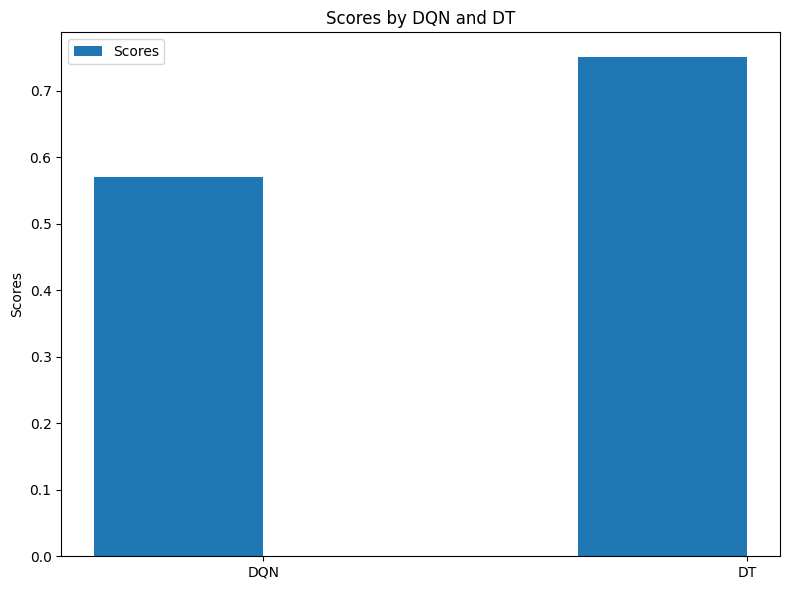

In [ ]:
# We will make a bar chart to compare the performance of DQN and DT

import matplotlib.pyplot as plt

labels = ['DQN', 'DT']
scores = [dqn_score, dt_score]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, scores, width, label='Scores')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by DQN and DT')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

